In [29]:
import pickle
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.layers import Dropout, MaxPooling1D, Reshape, Conv1D, Dense,Input, Flatten
from keras.models import  Model
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

from scipy.interpolate import splev, splrep
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import random


In [3]:
base_dir = "./dataset"
#os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
ir = 3  # interpolate interval
before = 2
after = 2
# normalize
#MinMaxScaler()
scaler = lambda arr: (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

In [4]:
tm = np.arange(0, (before + 1 + after) * 60, step=1 / float(ir))

In [5]:
path = "apnea-ecg.pkl"

In [6]:
with open(os.path.join(base_dir, path), 'rb') as f:  # read preprocessing result
        apnea_ecg = pickle.load(f)

In [7]:
def load_data():
    tm = np.arange(0, (before + 1 + after) * 60, step=1 / float(ir))

    with open(os.path.join(base_dir, "apnea-ecg.pkl"), 'rb') as f: # read preprocessing result
        apnea_ecg = pickle.load(f)

    x_training = []
    o_train, y_training = apnea_ecg["o_train"], apnea_ecg["y_train"]
    groups_training = apnea_ecg["groups_train"]
    for i in range(len(o_train)):
        (rri_tm, rri_signal), (ampl_tm, ampl_siganl) = o_train[i]
		# Curve interpolation
        rri_interp_signal = splev(tm, splrep(rri_tm, scaler(rri_signal), k=3), ext=1) 
        ampl_interp_signal = splev(tm, splrep(ampl_tm, scaler(ampl_siganl), k=3), ext=1)
        x_training.append([rri_interp_signal, ampl_interp_signal])
    x_train, y_train, groups_train = [], [], []
    x_val, y_val, groups_val = [], [], []


    random.seed(32)
    trainlist = random.sample(range(len(o_train)),int(len(o_train)*0.7))
    num = [i for i in range(16709)]
    vallist = set(num) - set(trainlist)
    vallist = list(vallist)

    for i in trainlist:
        x_train.append(x_training[i])
        y_train.append(y_training[i])
        groups_train.append(groups_training[i])

    for i in vallist:
        x_val.append(x_training[i])
        y_val.append(y_training[i])
        groups_val.append(groups_training[i])

    x_train = np.array(x_train, dtype="float32").transpose((0, 2, 1))
    y_train = np.array(y_train, dtype="float32")
    x_val = np.array(x_val, dtype="float32").transpose((0, 2, 1))
    y_val = np.array(y_val, dtype="float32")



    x_test = []
    o_test, y_test = apnea_ecg["o_test"], apnea_ecg["y_test"]
    groups_test = apnea_ecg["groups_test"]
    
    for i in range(len(o_test)):
        (rri_tm, rri_signal), (ampl_tm, ampl_siganl) = o_test[i]
		# Curve interpolation
        rri_interp_signal = splev(tm, splrep(rri_tm, scaler(rri_signal), k=3), ext=1)
        ampl_interp_signal = splev(tm, splrep(ampl_tm, scaler(ampl_siganl), k=3), ext=1)

        x_test.append([rri_interp_signal, ampl_interp_signal])
    x_test = np.array(x_test, dtype="float32").transpose((0, 2, 1))
    y_test = np.array(y_test, dtype="float32")

    return x_train, y_train, groups_train, x_val, y_val, groups_val, x_test, y_test, groups_test


In [8]:
x_train, y_train, groups_train, x_val, y_val, groups_val, x_test, y_test, groups_test = load_data()

y_train = keras.utils.to_categorical(y_train, num_classes=2) # Convert to two categories
y_test = keras.utils.to_categorical(y_test, num_classes=2)
y_val = keras.utils.to_categorical(y_val, num_classes=2)

print("train num:", len(y_train))
print("test num:", len(y_test))
print("val num:", len(y_val))

train num: 11696
test num: 16945
val num: 5013


In [9]:
weight=1e-3
input_shape = x_train.shape[1:]

tf.random.set_seed(32)

inputs = Input(shape=input_shape, name="Input_Layer")

	# Conv1
x = Conv1D(32, kernel_size=5, strides=2, padding="valid", activation="relu", kernel_initializer="he_normal",
               kernel_regularizer=l2(), bias_regularizer=l2(weight))(inputs)
x = MaxPooling1D(pool_size=3)(x)

	# Conv3
x = Conv1D(64, kernel_size=5, strides=2, padding="valid", activation="relu", kernel_initializer="he_normal",
               kernel_regularizer=l2(1e-3), bias_regularizer=l2(weight))(x)
x = MaxPooling1D(pool_size=3)(x)

# Conv3

# x = Conv1D(128, 5,strides=2, activation="relu", name = "Conv1d_3")(x)
# x = MaxPooling1D(pool_size=3, name = "Maxpooling1D_3")(x)

x = Dropout(0.8)(x) # Avoid overfitting

	# FC6
x = Flatten()(x)
x = Dense(32, activation="relu")(x)
outputs = Dense(2, activation="softmax")(x) # sigmoid

model_1 = Model(inputs=inputs, outputs=outputs)

# Compile the model
model_1.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy']) # binary_crossentropy


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-01-09 13:51:09.505599: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-09 13:51:09.506870: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
# Model Summary
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 900, 2)]          0         
                                                                 
 conv1d (Conv1D)             (None, 448, 32)           352       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 149, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 73, 64)            10304     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 24, 64)           0         
 1D)                                                             
                                                                 
 dropout (Dropout)           (None, 24, 64)            0     

In [11]:
def lr_schedule(epoch, lr):
    if epoch > 70 and (epoch) % 10 == 0:
        lr *= 0.1
    print("Learning rate: ", lr)
    return lr

In [12]:
def plot(history):
    """Plot performance curve"""
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].plot(history["loss"], "r-", history["val_loss"], "b-", linewidth=0.5)
    axes[0].set_title("Loss")
    axes[1].plot(history["accuracy"], "r-", history["val_accuracy"], "b-", linewidth=0.5)
    axes[1].set_title("Accuracy")



In [13]:
# Fit the model
lr_scheduler = LearningRateScheduler(lr_schedule) # Dynamic adjustment learning rate

history = model_1.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_val, y_val),
                        callbacks=[lr_scheduler])

Learning rate:  0.0010000000474974513
Epoch 1/100


2023-01-09 13:51:10.002821: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-09 13:51:10.357456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - ETA: 0s - loss: 1.3549 - accuracy: 0.6043

2023-01-09 13:51:12.578247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - 3s 25ms/step - loss: 1.3549 - accuracy: 0.6043 - val_loss: 1.1903 - val_accuracy: 0.6525 - lr: 0.0010
Learning rate:  0.0010000000474974513
Epoch 2/100
92/92 [==============================] - 2s 21ms/step - loss: 1.0802 - accuracy: 0.6931 - val_loss: 0.9350 - val_accuracy: 0.7662 - lr: 0.0010
Learning rate:  0.0010000000474974513
Epoch 3/100
92/92 [==============================] - 2s 22ms/step - loss: 0.9035 - accuracy: 0.7635 - val_loss: 0.8203 - val_accuracy: 0.8005 - lr: 0.0010
Learning rate:  0.0010000000474974513
Epoch 4/100
92/92 [==============================] - 2s 21ms/step - loss: 0.8076 - accuracy: 0.7917 - val_loss: 0.7295 - val_accuracy: 0.8257 - lr: 0.0010
Learning rate:  0.0010000000474974513
Epoch 5/100
92/92 [==============================] - 2s 21ms/step - loss: 0.7403 - accuracy: 0.8044 - val_loss: 0.6824 - val_accuracy: 0.8320 - lr: 0.0010
Learning rate:  0.0010000000474974513
Epoch 6/100
92/92 [============================

In [14]:
# Test the model
loss, accuracy = model_1.evaluate(x_test, y_test)
print("Test loss: ", loss)
print("Accuracy: ", accuracy)

# ks = 3
#pool = 3
#layers = 2


530/530 [==============================] - 4s 8ms/step - loss: 0.3388 - accuracy: 0.8717
Test loss:  0.3387962579727173
Accuracy:  0.8717025518417358


In [15]:
def plot(history):
    """Plot performance curve"""
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].plot(history["loss"], "r-", history["val_loss"], "b-")
    axes[0].set_title("Loss")
    axes[1].plot(history["accuracy"], "r-", history["val_accuracy"], "b-")
    axes[1].set_title("Accuracy")

    fig.show()

/var/folders/dq/8rpvsfrx7pv2z_fs5jrd0mtm0000gn/T/ipykernel_77485/1985733069.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


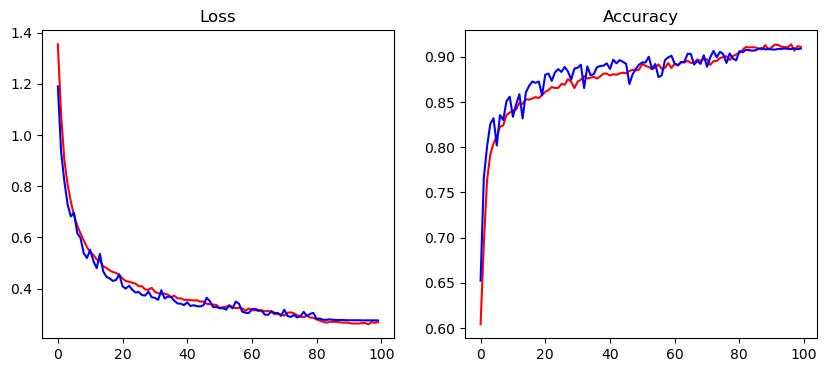

In [16]:
plot(history.history)

In [17]:
# save prediction score
y_score = model_1.predict(x_test)
output = pd.DataFrame({"y_true": y_test[:, 1], "y_score": y_score[:, 1], "subject": groups_test})
output.to_csv(os.path.join("output", "Results.csv"))

 72/530 [===>..........................] - ETA: 0s

2023-01-09 13:54:24.999645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


530/530 [==============================] - 1s 2ms/step


In [18]:
output = pd.DataFrame({"y_true": y_test[:, 1], "y_score": y_score[:, 1], "subject": groups_test})

y_true, y_pred = np.argmax(y_test, axis=-1), np.argmax(model_1.predict([x_test], batch_size=1024, verbose=1), axis=-1)

p_s = precision_score(y_true, y_pred)
print("Precision : ", p_s)

f1_score = f1_score(y_true, y_pred)
print("F1_Score: ", f1_score)

recall = recall_score(y_true, y_pred)
print("Recall: ", recall)



# TP, TN, FP, FN = C[0, 0], C[1, 1], C[1, 0], C[0, 1]
# acc, sn, sp = 1. * (TP + TN) / (TP + TN + FP + FN), 1. * TP / (TP + FN), 1. * TN / (TN + FP)
# f1 = f1_score(y_true, y_pred, average='binary')
# print("acc: {}, sn: {}, sp: {}, f1: {}".format(acc, sn, sp, f1))


 9/17 [==============>...............] - ETA: 0s

2023-01-09 13:54:26.554825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 0s 17ms/step
Precision :  0.8440688775510204
F1_Score:  0.8296505249960822
Recall:  0.8157164869029275


In [19]:
cm = np.flip(confusion_matrix(y_true, y_pred))

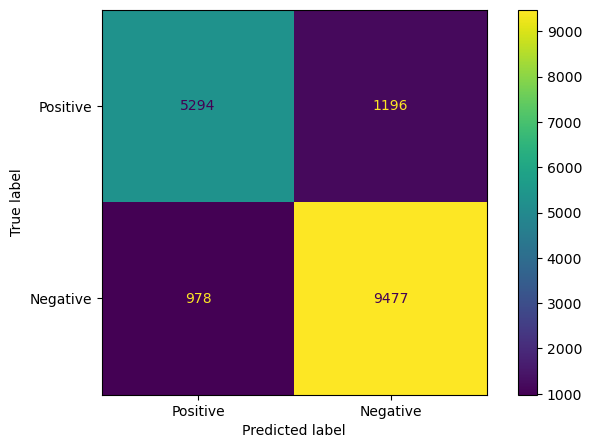

In [20]:
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(cm, display_labels=[ "Positive", "Negative"])
cmp.plot(ax=ax)

In [21]:
output.sort_values(by = "subject", inplace=True)

In [22]:
output = output.groupby('subject').mean().reset_index()

In [23]:
output

,subject,y_true,y_score
0,x01,0.737673,0.643679
1,x02,0.452381,0.442896
2,x03,0.026030,0.072855
3,x04,0.000000,0.023078
4,x05,0.628000,0.750281
5,x06,0.000000,0.069110
6,x07,0.470238,0.474107
7,x08,0.627680,0.633958
8,x09,0.332008,0.401669
9,x10,0.190099,0.231195


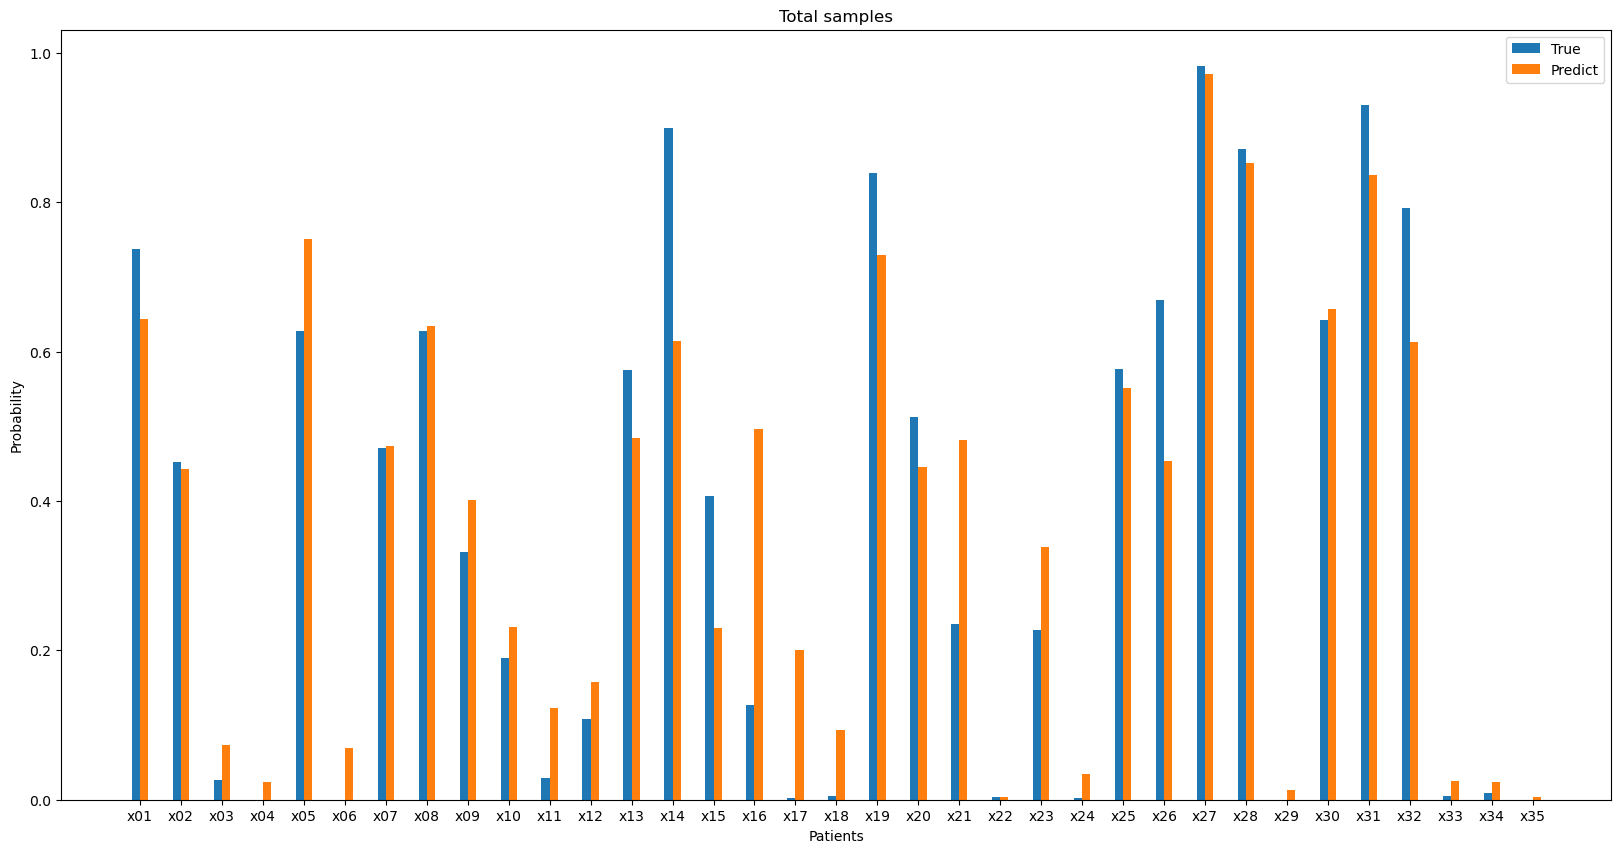

In [24]:
X_axis = np.arange(1,len(output.subject)+1)

plt.figure(figsize=(20, 10))
plt.bar(X_axis - 0.1, output.y_true, 0.2, label = 'True')
plt.bar(X_axis + 0.1, output.y_score, 0.2, label = 'Predict')

plt.xticks(X_axis, output.subject)
plt.xlabel("Patients")
plt.ylabel("Probability")
plt.title("Total samples")
plt.legend()

plt.show()

In [25]:
from keras.utils import plot_model

plot_model(model_1, "model.png") # Plot model

model_1.save(os.path.join("Model", "model.final.h5")) # Save training model

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
